In [20]:
#dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from scipy.spatial.distance import cdist
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pynumdiff

#plots
import figurefirst
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()

#misc
import time
np.set_printoptions(suppress=True)



In [21]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'ContinuousNotWindy_.h5')

In [22]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

# ## getting the indexes for odor over a threshold to determine each encounter
# def get_index(df):
#     idx = []
#     for i in range(len(df.filtered_odor)):
#         if (df.filtered_odor[i]>4):
#             idx.append(df.index[i])

#     from itertools import groupby
#     from operator import itemgetter
#     index = [ ]
#     for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
#         index.append((list((map(itemgetter(1), g)))))
#     return index

def get_index(df):
    idx = []
    for i in range(len(df.odor)):
        if (df.odor[i]>4):
            idx.append(df.index[i])

    from itertools import groupby
    from operator import itemgetter
    index = []
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

In [23]:
fdf=pd.DataFrame()
index = get_index(df)

#Distance

i = 0
avg_dist_source = []
while i<len(index):
    avg_dist_source.append(np.mean(df.distance_from_source[index[i]])) ## _ is declination corrected distance
    i+=1
fdf['avg_dist_from_source']=avg_dist_source

avg_dist_from_streakline = []

i = 0
while i<len(index):
    avg_dist_from_streakline.append(np.mean(df.nearest_from_streakline_[index[i]]))
    i+=1
fdf['avg_dist_from_streakline']=avg_dist_from_streakline

# RELATIVE MOTION

# rel_parallel_enc = []
# i= 0
# while i<len(index):
#     rel_parallel_enc.append(np.mean(df.relative_parallel_comp[index[i]]))
#     i+=1
# fdf['avg_parallel_encounter']=rel_parallel_enc


# rel_perpendicular_enc = []
# i= 0
# while i<len(index):
#     rel_perpendicular_enc.append(np.mean(df.relative_perpendicular_comp[index[i]]))
#     i+=1
# fdf['avg_perpendicular_encounter']=rel_perpendicular_enc


# rel_parallel_inter = []
# i= 0
# while i < len(index):
#     if i < (len(index)-1):
#         rel_parallel_inter.append(np.mean(df.relative_parallel_comp[index[i][-1]:index[i+1][0]]))
#         i+=1
#     else:
#         rel_parallel_inter.append(0)
#         i+=1

# fdf['avg_parallel_intermittency']=rel_parallel_inter

       
# rel_perpendicular_inter = []
# i= 0
# while i < len(index):
#     if i < (len(index)-1):
#         rel_perpendicular_inter.append(np.mean(df.relative_perpendicular_comp[index[i][-1]:index[i+1][0]]))
#         i+=1
#     else:
#         rel_perpendicular_inter.append(0)
#         i+=1
        
# fdf['avg_perpendicular_intermittency']=rel_perpendicular_inter

print('done')

done


In [24]:
# time of the encounters
i = 0
length_of_encounter = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    length_of_encounter.append(dt*(len(index[i])))
    i+=1
fdf['length_of_encounter'] = length_of_encounter

#time between the encounters
i = 0
intermittency = []
while i < len(index):
    if i < (len(index)-1):
        intermittency.append((index[i+1][0] - index[i][-1])*dt)
        i+=1
    else:
        intermittency.append(0)
        i+=1
fdf['odor_intermittency'] = intermittency

## Trajectory speed during Intermittency
i = 0
speed_at_intermittency=[]
while i < len(index):
    if i < (len(index)-1):
        x = np.mean(df.gps_linear_x[index[i][-1]:index[i+1][0]])
        y = np.mean(df.gps_linear_y[index[i][-1]:index[i+1][0]])
        z = np.mean(df.gps_linear_z[index[i][-1]:index[i+1][0]])
        speed_at_intermittency.append(np.sqrt(x**2+y**2+z**2))
        i+=1
    else:
        speed_at_intermittency.append(0)
        i+=1

fdf['speed_at_intermittency'] = speed_at_intermittency

## Trajectory speed during Encounters
i = 0
speed_at_encounter=[]
while i < len(index):
        x = np.mean(df.gps_linear_x[index[i]])
        y = np.mean(df.gps_linear_y[index[i]])
        z = np.mean(df.gps_linear_z[index[i]])
        speed_at_encounter.append(np.sqrt(x**2+y**2+z**2))
        i+=1
fdf['speed_at_encounter'] = speed_at_encounter

print('done')

done


In [25]:
# binary vector
start = []
for i in range (len(index)):
    start.append(index[i][0])
df['efreq'] = np.zeros(len(df))
df.efreq.iloc[start] = 1

## encounter frequency
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

t = df.time[:8008]
tau = 2
kernel = exp_ker(t,tau)

filtered = signal.convolve(df.efreq, kernel, mode='same', method='auto')
df['encounter_frequency']=filtered

#Average Encounter Frequency
i = 0
wfreq = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    wfreq.append(np.mean(df.encounter_frequency[index[i]]))
    i+=1
fdf['mean_encounter_frequency'] = wfreq

In [26]:
## Avg slope calculation
x=df.odor
y=df.time

params1 = [3, 1000, 200] ## Filter Design
x_hat, dxdt_hat = pynumdiff.linear_model.savgoldiff(x, dt, params1)

In [27]:
i = 0
xhat = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    xhat.append(np.mean(x_hat[index[i]]))
    i+=1
fdf['estimated_odor_xhat'] = xhat

i = 0
dxdthat = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    dxdthat.append(np.mean(dxdt_hat[index[i]]))
    i+=1
fdf['odor_derivative'] = dxdthat

In [28]:
### Wind speed during encounter and Intermittency
i = 0
wind_speed_encounter = []
while i<len(index):
    wind_speed_encounter.append(np.mean(df.S2[index[i]]))
    i+=1
fdf['wind_speed_encounter'] = wind_speed_encounter

### Wind speed during intermittency
i = 0
wind_speed_intermittency = []
while i<len(index):
    if i < (len(index)-1):
        wind_speed_intermittency.append(np.mean(df.S2[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        wind_speed_intermittency.append(0)
        i+=1
fdf['wind_speed_intermittency'] = wind_speed_intermittency

In [116]:
fdf  = fdf.drop(fdf.index[0:136]) # 78 rows for 2Hz
                                 # 136 rows for 4Hz; 
                                 # 148 rows for 8hz ; 
                                 # 165 rows for 10Hz; 232 rows for 20hz; 291 rows for 40hz
                                 # 319 rows for 60Hz
                                 # 339 rows for 80Hz 
fdf.reset_index(inplace=True, drop=True) 

In [29]:
fdf['log_whiff']=np.log10(fdf.length_of_encounter)
fdf['log_blank']=np.log10(fdf.odor_intermittency)
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# fdf.to_hdf(dir+'WindyStats_.h5', key='fdf', mode='w')

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
fdf = pd.read_hdf(dir+'WindyStats_.h5')

In [30]:
fdf = fdf.sort_values(by=['avg_dist_from_source'])
fdf.reset_index(inplace=True, drop=True) 

In [31]:
a = np.array(np.where(fdf.avg_dist_from_source <=10))
b = np.array(np.where((fdf.avg_dist_from_source > 10) & (fdf.avg_dist_from_source <=30)))
c = np.array(np.where(fdf.avg_dist_from_source > 30))
fdf1 = pd.DataFrame()
fdf2 = pd.DataFrame()
fdf3 = pd.DataFrame()

fdf1['distance_from_source_bin'] = np.repeat('0-10(m)',a.flatten().size)
fdf2['distance_from_source_bin'] = np.repeat('10-30(m)',b.flatten().size)
fdf3['distance_from_source_bin'] = np.repeat('>30(m)',c.flatten().size)
fdf['distance_from_source_bin'] = pd.concat([fdf1,fdf2,fdf3], ignore_index=True)
# 

In [32]:
fdf.keys()

Index(['avg_dist_from_source', 'avg_dist_from_streakline',
       'length_of_encounter', 'odor_intermittency', 'speed_at_intermittency',
       'speed_at_encounter', 'mean_encounter_frequency', 'estimated_odor_xhat',
       'odor_derivative', 'wind_speed_encounter', 'wind_speed_intermittency',
       'log_whiff', 'log_blank', 'distance_from_source_bin'],
      dtype='object')

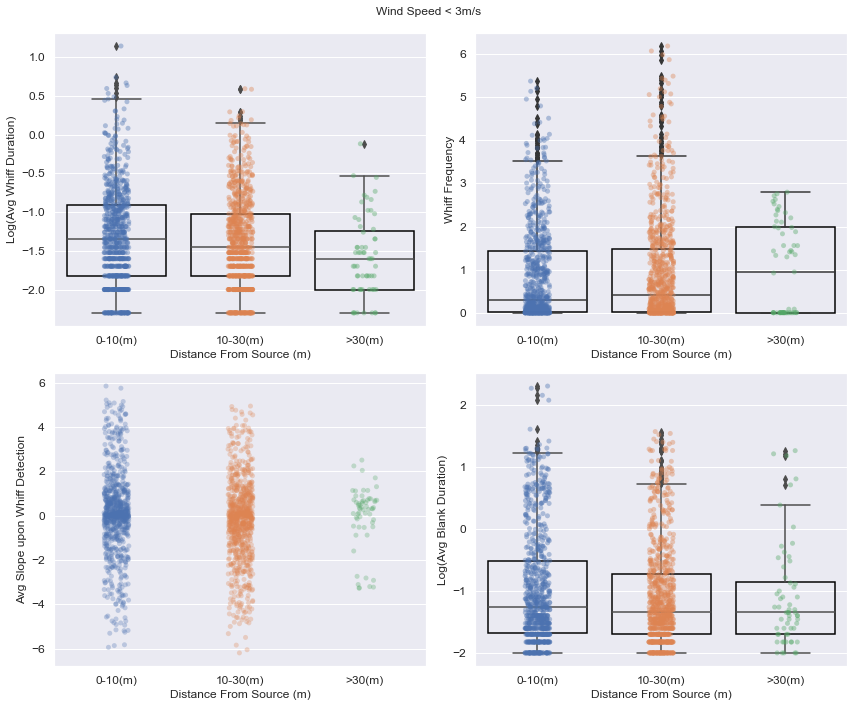

In [33]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,10)
                    ,gridspec_kw={'height_ratios':[3,3],'width_ratios': [4,4]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf,  dodge=True,  ax=ax1 )
for i,box in enumerate(ax1.artists):
    box.set_edgecolor('black')
    box.set_facecolor('None')
sns.stripplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)

ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Log(Avg Whiff Duration)')

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
for i,box in enumerate(ax2.artists):
    box.set_edgecolor('black')
    box.set_facecolor('None')
    
sns.stripplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)

ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')

#Avg Slope
sns.stripplot(x="distance_from_source_bin", y="odor_derivative", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Avg Slope upon Whiff Detection')

#Blank Frequency
sns.stripplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf, dodge='True',alpha=0.4, ax=ax4)
sns.boxplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf,  dodge=True, ax=ax4 )
for i,box in enumerate(ax4.artists):
    box.set_edgecolor('black')
    box.set_facecolor('None')
ax4.set_xlabel('Distance From Source (m)')
ax4.set_ylabel('Log(Avg Blank Duration)')

f.suptitle('Wind Speed < 3m/s')
f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 12)
f.savefig('../../Figure/odorStatsContNotWindy.jpeg')

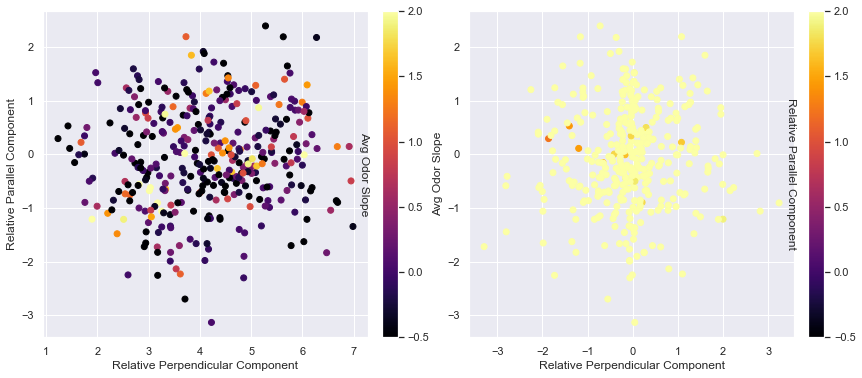

In [176]:
f, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6)) 
#                             gridspec_kw={'height_ratios':[3,3],'width_ratios': [4,4]})

min_val = -0.5
max_val = 2
lblpad = -60
var = ax1.scatter(fdf.avg_parallel_encounter, fdf.avg_perpendicular_encounter, 
                  c=(fdf.odor_derivative), cmap='inferno', vmin=min_val, vmax=max_val)


ax1.set_ylabel('Relative Parallel Component')
ax1.set_xlabel('Relative Perpendicular Component')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.2)
f.colorbar(var, cax=cax, orientation = 'vertical')
cax.get_yaxis().labelpad = lblpad
cax.set_ylabel('Avg Odor Slope', rotation=270)

var1 = ax2.scatter(fdf.odor_derivative, fdf.avg_perpendicular_encounter, 
                  c=fdf.avg_parallel_encounter, cmap='inferno', vmin=min_val, vmax=max_val)


ax2.set_ylabel('Avg Odor Slope')
ax2.set_xlabel('Relative Perpendicular Component')
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.2)
f.colorbar(var1, cax=cax1, orientation = 'vertical')
cax1.get_yaxis().labelpad = lblpad
cax1.set_ylabel('Relative Parallel Component', rotation=270)


# f.savefig('../../Figure/odorderiv-motioncompspeed.jpeg')

In [20]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
fdf = pd.read_hdf(dir+'WindyStats.h5')

In [21]:
pd.set_option('use_inf_as_na', True)

In [34]:
encounter_freq=smf.ols(formula='np.log10(mean_encounter_frequency) ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
encounters=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
intermittencies=smf.ols(formula='log_blank ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
oderivatives = smf.ols(formula='odor_derivative ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()

# # print(encounters.summary())
# plt.rc('figure', figsize=(12, 6))
# plt.text(0.01, 0.05, str(intermittencies.summary()), {'fontsize': 12}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/intermittencyreg.jpeg')

In [35]:
fdf['encounterfreq_resid']=encounter_freq.resid
fdf['encounter_resid'] = encounters.resid
fdf['intermittency_resid'] = intermittencies.resid
fdf['odorderivative_resid'] = oderivatives.resid

In [36]:
distance=smf.ols(formula='avg_dist_from_source ~ odorderivative_resid + encounterfreq_resid+ encounter_resid + intermittency_resid', data=fdf).fit()
print(distance.summary())
# plt.rc('figure', figsize=(12, 6))
# plt.text(0.01, 0.05, str(distance.summary()), {'fontsize': 12}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/windyreg.jpeg')

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.119
Model:                              OLS   Adj. R-squared:                  0.114
Method:                   Least Squares   F-statistic:                     23.41
Date:                  Thu, 14 Oct 2021   Prob (F-statistic):           3.61e-18
Time:                          12:17:48   Log-Likelihood:                -2600.4
No. Observations:                   697   AIC:                             5211.
Df Residuals:                       692   BIC:                             5233.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

In [101]:
# regresult=pd.DataFrame()
# regresult['cutoff_frequency'] = np.array([2,4,8,10,20,40,60,80])
# regresult['Rsquare'] = np.array([0.141,0.166,0.136,0.135,0.147,0.152,0.161,0.195])
# regresult['speed']=np.array([0.3322,0.3757,0.3454,0.3450,0.3590,0.3638,0.3692, 0.4009])
# regresult['encounter']=np.array([0.0218, 0.0051,-0.0043,-0.0026, -0.0256,-0.0342,-0.0351,-0.0271])
# regresult['intermittency']=np.array([-0.0220, -0.0171,-0.0119,-0.0053,-0.0169,-0.0230,-0.0262,-0.0224])

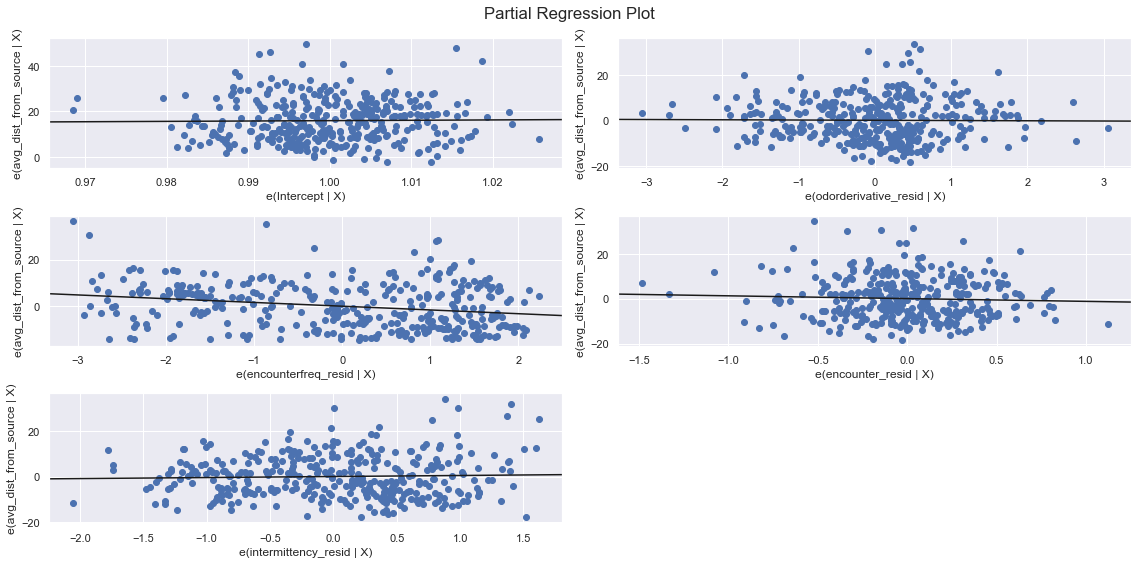

In [131]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)
fig = sm.graphics.plot_partregress_grid(distance)
fig.tight_layout(pad=1.0)
plt.savefig('../../Figure/partreg.jpeg')

In [73]:
# f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

# ax1.plot(regresult.cutoff_frequency, regresult.Rsquare)
# ax1.scatter(regresult.cutoff_frequency, regresult.Rsquare)
# ax1.set_ylabel('$R^2$')
# ax1.set_xlabel('Cutoff_Frequency')
# ax1.set_xticks(regresult.cutoff_frequency)
# # ax1.set_yticks(regresult.Rsquare)

# ax2.plot(regresult.cutoff_frequency, regresult.speed, label='Speed_at_encounter')
# ax2.plot(regresult.cutoff_frequency, regresult.encounter, label ='Corrected_Encounter')
# ax2.plot(regresult.cutoff_frequency, regresult.intermittency, label = 'Corrected_Intermittency')
# ax2.set_xticks(regresult.cutoff_frequency)
# ax2.legend()
# ax2.set_ylabel('Coefficients')
# ax2.set_xlabel('Cutoff_Frequency')
# f.tight_layout()
# figurefirst.mpl_functions.set_fontsize(f,12)
# plt.savefig('../../Figure/regressionsummary.jpeg')

#### Not Required Stats

In [ ]:

## Odor Standard Deviation
i = 0
st_dev = []
while i<len(index):
    st_dev.append(np.std(df.odor[index[i]]))
    i+=1
fdf['odor_stdev'] = st_dev

## Trisonica Mean Pressure
i = 0
pressure = []
while i<len(index):
    pressure.append(np.mean(df.trisonica_pressure[index[i]]))
    i+=1
fdf['tri_pressure'] = pressure

## Trisonica Mean Temperature
i = 0
temperature = []
while i<len(index):
    temperature.append(np.mean(df.trisonica_temperature[index[i]]))
    i+=1
fdf['tri_temperature'] = temperature

## Trisonica Mean Linear acceleration
i = 0
linear_acc_x = []
while i<len(index):
    linear_acc_x.append(np.mean(df.imu_linear_acc_x[index[i]]))
    i+=1
fdf['linear_acc_x'] = linear_acc_x

i = 0
linear_acc_y = []
while i<len(index):
    linear_acc_y.append(np.mean(df.imu_linear_acc_y[index[i]]))
    i+=1
fdf['linear_acc_y'] = linear_acc_y

i = 0
linear_acc_z = []
while i<len(index):
    linear_acc_z.append(np.mean(df.imu_linear_acc_z[index[i]]))
    i+=1
fdf['linear_acc_z'] = linear_acc_z

## Trisonica Mean Angular vel
i = 0
angular_vel_x = []
while i<len(index):
    angular_vel_x.append(np.mean(df.imu_angular_x[index[i]]))
    i+=1
fdf['imu_angular_x'] = angular_vel_x

i = 0
angular_vel_y = []
while i<len(index):
    angular_vel_y.append(np.mean(df.imu_angular_y[index[i]]))
    i+=1
fdf['imu_angular_y'] = angular_vel_y

i = 0
angular_vel_z = []
while i<len(index):
    angular_vel_z.append(np.mean(df.imu_angular_z[index[i]]))
    i+=1
fdf['imu_angular_z'] = angular_vel_z

In [ ]:
# fig, ax = plt.subplots(figsize=(12,6))
# ax = sns.distplot(np.log(df1['length_of_encounter']), label = 'High Resolution')
# ax=sns.distplot(np.log(df2['length_of_encounter']), label = 'Low Resolution')
# ax.set_xlim(-8, 8)
# ax.legend()
# # fig.savefig('../../Figure/distplot.jpeg')